# **IMPORTS**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
MAIN_PATH = "/content/drive/MyDrive/Stress_dataset"

In [5]:
import os
print(os.listdir(MAIN_PATH))   # should show folders like 5C, 6B, 15, etc.

['SurveyResults.xlsx', 'combined_lagEDA.csv', 'BG', 'F5', 'E4', '8B', '94', 'CE', 'DF', 'EG', '83', '7E', '7A', '6D', '6B', '5C', '15', 'combined_lagEDA.xlsx', 'HR.csv', 'EDA.csv', 'ACC.csv', 'TEMP.csv', 'BVP.csv', 'Stress_dataset.zip']


In [7]:
import pandas as pd

sample_path = os.path.join(MAIN_PATH, "8B", "EDA.csv")
df = pd.read_csv(sample_path)
print(df.head())


   1595538351.000000
0           4.000000
1           0.000000
2           0.816306
3           0.987011
4           0.746091


In [9]:
!pip freeze >requirements.txt

In [ ]:
# Cell 1: Install & imports (run once)
# !pip install -q lightgbm imbalanced-learn

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# sklearn utilities
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score
)

# LightGBM (fast tabular boosting)
import lightgbm as lgb
# TensorFlow / Keras for CNN & LSTM models
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout,
    BatchNormalization, Flatten, LSTM, Reshape, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For optional balancing
from imblearn.over_sampling import SMOTE

# reproducibility
RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)
tf.random.set_seed(RSEED)

print("Imports ready. TensorFlow version:", tf.__version__)

Imports ready. TensorFlow version: 2.19.0


In [ ]:
# Cell 2: Config & load dataset
MAIN_PATH = "/content/drive/MyDrive/Stress_dataset"   # <- CHANGE to your path if required

# common filenames you may have
candidates = ["combined_lagEDA.csv", "combined_lagEDA.xlsx", "combined_lagEDA.tsv"]
data_path = None
for fn in candidates:
    full = os.path.join(MAIN_PATH, fn)
    if os.path.exists(full):
        data_path = full
        break

if data_path is None:
    raise FileNotFoundError(
        f"Could not find combined_lagEDA under {MAIN_PATH}. Put combined_lagEDA.csv there."
    )

# load as CSV or Excel
if data_path.lower().endswith(".csv"):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel(data_path)

print("Loaded dataframe:", data_path)
print("Shape:", df.shape)
display(df.head())

Loaded dataframe: /content/drive/MyDrive/Stress_dataset/combined_lagEDA.csv
Shape: (12445, 49)


,30,29,28,27,26,25,24,23,22,21,...,HRR_Mean,HRR_Min,HRR_Max,HRR_Std,HRR_RMS,TEMPR_Mean,TEMPR_Min,TEMPR_Max,TEMPR_Std,Stress
0,0.132578,0.123534,0.115152,0.110787,0.109565,0.106694,0.100631,0.093710,0.088657,0.084547,...,0.641552,0.639566,0.643243,0.100525,0.235069,0.821491,0.821239,0.823944,0.120422,0.0
1,0.123534,0.115152,0.110787,0.109565,0.106694,0.100631,0.093710,0.088657,0.084547,0.084598,...,0.642973,0.639566,0.643243,0.089270,0.229293,0.827471,0.828319,0.830986,0.105027,0.0
2,0.115152,0.110787,0.109565,0.106694,0.100631,0.093710,0.088657,0.084547,0.084598,0.089846,...,0.643921,0.640921,0.645946,0.083372,0.157093,0.832395,0.831858,0.834507,0.099446,0.0
3,0.110787,0.109565,0.106694,0.100631,0.093710,0.088657,0.084547,0.084598,0.089846,0.094890,...,0.645952,0.644986,0.645946,0.041375,0.131024,0.837759,0.842478,0.839789,0.089739,0.0
4,0.109565,0.106694,0.100631,0.093710,0.088657,0.084547,0.084598,0.089846,0.094890,0.098347,...,0.646764,0.644986,0.648649,0.066093,0.113470,0.843123,0.846018,0.848592,0.095171,0.0


In [ ]:
# Cell 3: Identify features & target, basic preprocess

# Try common target names, else fall back to the last column
target_candidates = ['label', 'target', 'Stress level', 'Stress', 'stress', 'label_enc']
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    target_col = df.columns[-1]
    print("No common target name found – using last column:", target_col)

# prepare X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col])

# encode y if object
if y.dtype == object:
    le = LabelEncoder()
    y = le.fit_transform(y)
else:
    y = y.astype(int)

print("Target distribution (label:count):", np.unique(y, return_counts=True))

# If any object columns present, label-encode them (rare for feature matrix)
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    print("Encoding categorical columns:", cat_cols)
    for c in cat_cols:
        X[c] = LabelEncoder().fit_transform(X[c].astype(str))

# numeric scaling — standardize features for DL and LGBM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
X = pd.DataFrame(X_scaled, columns=X.columns)

print("Prepared features shape:", X.shape)

Target distribution (label:count): (array([0, 1, 2]), array([5410, 2250, 4785]))
Prepared features shape: (12445, 48)


In [ ]:
# Cell 4: Create pseudo-sequences for DL models

def tabular_to_seq(X_arr, seq_len=12):
    """
    Convert tabular (n_samples, n_features) -> sequences (n_samples, seq_len, feat_per_step).
    This pads with zeros if needed. seq_len is a hyperparameter (tune it).
    """
    n_samples, n_features = X_arr.shape
    features_per_step = int(np.ceil(n_features / seq_len))
    padded = np.zeros((n_samples, seq_len * features_per_step), dtype=X_arr.dtype)
    padded[:, :n_features] = X_arr
    seq = padded.reshape(n_samples, seq_len, features_per_step)
    return seq

SEQ_LEN = 12  # tune: 8,12,16,... depending on features / experiments
X_seq = tabular_to_seq(X.values, seq_len=SEQ_LEN)
print("Sequence shape (for DL):", X_seq.shape, "(n_samples, seq_len, feat_per_step)")

Sequence shape (for DL): (12445, 12, 4) (n_samples, seq_len, feat_per_step)


In [ ]:
# Cell 5: Train/test split & sequence variants

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.20, random_state=RSEED, stratify=y
)

# reset indices to align positions with OOF indexing
X_train_full = X_train_full.reset_index(drop=True)
X_test_full  = X_test_full.reset_index(drop=True)
y_train_full = y_train_full.reset_index(drop=True)
y_test_full  = y_test_full.reset_index(drop=True)

# sequences for train/test
X_seq_train = tabular_to_seq(X_train_full.values, seq_len=SEQ_LEN)
X_seq_test  = tabular_to_seq(X_test_full.values, seq_len=SEQ_LEN)

print("Train tabular:", X_train_full.shape, "Train seq:", X_seq_train.shape)
print("Test tabular:", X_test_full.shape, "Test seq:", X_seq_test.shape)

Train tabular: (9956, 48) Train seq: (9956, 12, 4)
Test tabular: (2489, 48) Test seq: (2489, 12, 4)


In [ ]:
# Cell 6:CNN model builder (High-accuracy CNN)

def build_cnn_model(input_shape, n_classes, dropout_rate=0.3):
    """
    Improved 1D CNN with dilated convolutions + residual skip connection
    Designed to increase accuracy to 90%+
    """
    from tensorflow.keras.layers import (
        Input, Conv1D, BatchNormalization, Add,
        GlobalAveragePooling1D, Dense, Dropout
    )
    from tensorflow.keras.models import Model

    inp = Input(shape=input_shape, name='cnn_input')

    # ---------- Block 1 ----------
    x = Conv1D(64, kernel_size=7, padding='same', activation='relu')(inp)
    x = BatchNormalization()(x)

    # ---------- Block 2: Dilated Convolution + Residual ----------
    d = Conv1D(
        128,
        kernel_size=9,
        dilation_rate=2,
        padding='same',
        activation='relu'
    )(x)
    d = BatchNormalization()(d)

    # Shortcut Connection
    shortcut = Conv1D(128, kernel_size=1, padding='same')(x)

    # Add residual
    x = Add()([d, shortcut])

    # ---------- Block 3 ----------
    x = Conv1D(256, kernel_size=11, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # ---------- Global Pooling ----------
    x = GlobalAveragePooling1D()(x)

    # ---------- Dense Head ----------
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out, name="Improved_CNN")

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Instantiation test (optional)
cnn_test = build_cnn_model((SEQ_LEN, X_seq_train.shape[2]), n_classes=len(np.unique(y)))
cnn_test.summary()
del cnn_test

Model: "Improved_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 12, 64)    │      1,856 │ cnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 12, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 128)   │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 128)   │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 12, 256)   │    360,704 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 256)   │      1,024 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 479,811 (1.83 MB)

 Trainable params: 478,915 (1.83 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:

# Cell 7:LSTM model builder (with residual skip + dense bottleneck)

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model

def build_lstm_model(input_shape, n_classes, dropout_rate=0.3):
    """
    Improved LSTM model:
    - Larger LSTM units (96)
    - Residual skip connection
    - BatchNorm + two dropout layers
    - Dense bottleneck layer for feature compression
    - Softmax output layer
    """

    inp = Input(shape=input_shape, name='lstm_input')

    # First LSTM block
    x = LSTM(96, return_sequences=True, name='lstm_block1')(inp)
    x = BatchNormalization(name='lstm_bn1')(x)
    x = Dropout(dropout_rate, name='lstm_drop1')(x)

    # Second LSTM block (no return_sequences)
    x2 = LSTM(96, return_sequences=False, name='lstm_block2')(x)
    x2 = BatchNormalization(name='lstm_bn2')(x2)

    # Residual / Skip connection
    # Convert input through a Dense layer to match dimension (96)
    skip = Dense(96, activation='linear', name='lstm_skip_align')(inp[:, -1, :])
    x = Add(name='lstm_residual')([x2, skip])

    # Dense bottleneck
    x = Dense(48, activation='relu', name='lstm_dense1')(x)
    x = Dropout(0.25, name='lstm_drop2')(x)

    # Output layer
    out = Dense(n_classes, activation='softmax', name='lstm_output')(x)

    model = Model(inputs=inp, outputs=out, name='Improved_LSTM')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# quick instantiation test (NO training)
lstm_test = build_lstm_model((SEQ_LEN, X_seq_train.shape[2]), n_classes=len(np.unique(y)))
lstm_test.summary()
del lstm_test

Model: "Improved_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_block1 (LSTM)  │ (None, 12, 96)    │     38,784 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn1            │ (None, 12, 96)    │        384 │ lstm_block1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_drop1          │ (None, 12, 96)    │          0 │ lstm_bn1[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_block2 (LSTM)  │ (None, 96)        │     74,112 │ lstm_drop1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 4)         │          0 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn2            │ (None, 96)        │        384 │ lstm_block2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_skip_align     │ (None, 96)        │        480 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_residual (Add) │ (None, 96)        │          0 │ lstm_bn2[0][0],   │
│                     │                   │            │ lstm_skip_align[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dense1 (Dense) │ (None, 48)        │      4,656 │ lstm_residual[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_drop2          │ (None, 48)        │          0 │ lstm_dense1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_output (Dense) │ (None, 3)         │        147 │ lstm_drop2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,947 (464.64 KB)

 Trainable params: 118,563 (463.14 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Add, Bidirectional
from tensorflow.keras.models import Model

def build_bilstm_model(input_shape, n_classes, dropout_rate=0.3):
    """
    Build an improved BiLSTM model for sequence inputs.
    Includes batch normalization + residual skip connection.
    """

    inp = Input(shape=input_shape, name='bilstm_input')

    # First BiLSTM block (increased capacity)
    x = Bidirectional(
        LSTM(96, return_sequences=True, recurrent_dropout=0.2),
        name='bilstm_block1')(inp)

    x = BatchNormalization(name='bilstm_bn1')(x)
    x = Dropout(0.2, name='bilstm_drop1')(x)

    # Second BiLSTM block (reduced but stronger)
    x2 = Bidirectional(
        LSTM(64, return_sequences=False, recurrent_dropout=0.2),
        name='bilstm_block2')(x)

    x2 = BatchNormalization(name='bilstm_bn2')(x2)

    # Skip connection MUST match output dimension (2 × 64 = 128)
    skip = Dense(
        128,
        activation='linear',
        name='bilstm_skip')(inp[:, -1, :])

    # Residual add
    res = Add(name='bilstm_residual')([x2, skip])

    # Dense head
    x3 = Dense(64, activation='relu', name='bilstm_dense')(res)
    x3 = Dropout(0.25, name='bilstm_drop2')(x3)

    out = Dense(n_classes, activation='softmax', name='bilstm_output')(x3)

    model = Model(inputs=inp, outputs=out, name="Improved_BiLSTM")
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define n_classes here before instantiation test
n_classes = len(np.unique(y))

# quick instantiation test (NO training)
bilstm_test = build_bilstm_model((SEQ_LEN, X_seq_train.shape[2]), n_classes)
bilstm_test.summary()
del bilstm_test

Model: "Improved_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ bilstm_input        │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_block1       │ (None, 12, 192)   │     77,568 │ bilstm_input[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_bn1          │ (None, 12, 192)   │        768 │ bilstm_block1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_drop1        │ (None, 12, 192)   │          0 │ bilstm_bn1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_block2       │ (None, 128)       │    131,584 │ bilstm_drop1[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 4)         │          0 │ bilstm_input[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_bn2          │ (None, 128)       │        512 │ bilstm_block2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_skip (Dense) │ (None, 128)       │        640 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_residual     │ (None, 128)       │          0 │ bilstm_bn2[0][0], │
│ (Add)               │                   │            │ bilstm_skip[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_dense        │ (None, 64)        │      8,256 │ bilstm_residual[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_drop2        │ (None, 64)        │          0 │ bilstm_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_output       │ (None, 3)         │        195 │ bilstm_drop2[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 219,523 (857.51 KB)

 Trainable params: 218,883 (855.01 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Cell 8: OOF stacking for CNN + LSTM + LightGBM + BiLSTM
# (Optimized runtime, same methodology)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RSEED)

n_classes = len(np.unique(y))
n_models = 4  # LightGBM, CNN, LSTM, BiLSTM

# Meta-feature placeholders
oof_train = np.zeros((X_train_full.shape[0], n_models * n_classes), dtype=float)
oof_test  = np.zeros((X_test_full.shape[0], n_models * n_classes, n_splits), dtype=float)

fold_idx = 0

for train_idx, val_idx in skf.split(X_train_full, y_train_full):
    print(f"\n--- Fold {fold_idx+1}/{n_splits} ---")

    # -------------------------------
    # Tabular split
    # -------------------------------
    X_tr_tab, X_val_tab = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    # Sequence split
    X_tr_seq  = tabular_to_seq(X_tr_tab.values, seq_len=SEQ_LEN)
    X_val_seq = tabular_to_seq(X_val_tab.values, seq_len=SEQ_LEN)

    # 1) LightGBM (CPU)

    lgbm = lgb.LGBMClassifier(
        n_estimators=1000,        # keep for strong OOF signals
        learning_rate=0.02,
        max_depth=-1,
        random_state=RSEED
    )

    lgbm.fit(X_tr_tab, y_tr, eval_set=[(X_val_tab, y_val)])
    prob_val_lgb  = lgbm.predict_proba(X_val_tab)
    prob_test_lgb = lgbm.predict_proba(X_test_full)

    oof_train[val_idx, 0*n_classes:1*n_classes] = prob_val_lgb
    oof_test[:,     0*n_classes:1*n_classes, fold_idx] = prob_test_lgb


    # 2) CNN (GPU)

    tf.keras.backend.clear_session()
    cnn = build_cnn_model((SEQ_LEN, X_tr_seq.shape[2]), n_classes)

    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0)

    cnn.fit(
        X_tr_seq, y_tr,
        validation_data=(X_val_seq, y_val),
        epochs=45,                # OPTIMIZED
        batch_size=64,
        callbacks=[es, rl],
        verbose=0
    )

    prob_val_cnn  = cnn.predict(X_val_seq, verbose=0)
    prob_test_cnn = cnn.predict(X_seq_test, verbose=0)

    oof_train[val_idx, 1*n_classes:2*n_classes] = prob_val_cnn
    oof_test[:,     1*n_classes:2*n_classes, fold_idx] = prob_test_cnn

    # 3) LSTM (GPU)

    tf.keras.backend.clear_session()
    lstm = build_lstm_model((SEQ_LEN, X_tr_seq.shape[2]), n_classes)

    lstm.fit(
        X_tr_seq, y_tr,
        validation_data=(X_val_seq, y_val),
        epochs=45,                # OPTIMIZED
        batch_size=64,            # OPTIMIZED
        callbacks=[es, rl],
        verbose=0
    )

    prob_val_lstm  = lstm.predict(X_val_seq, verbose=0)
    prob_test_lstm = lstm.predict(X_seq_test, verbose=0)

    oof_train[val_idx, 2*n_classes:3*n_classes] = prob_val_lstm
    oof_test[:,     2*n_classes:3*n_classes, fold_idx] = prob_test_lstm

    # 4) BiLSTM (GPU – most expensive)

    tf.keras.backend.clear_session()
    bilstm = build_bilstm_model((SEQ_LEN, X_tr_seq.shape[2]), n_classes)

    bilstm.fit(
        X_tr_seq, y_tr,
        validation_data=(X_val_seq, y_val),
        epochs=60,                # OPTIMIZED
        batch_size=64,            # OPTIMIZED
        callbacks=[es, rl],
        verbose=0
    )

    prob_val_bilstm  = bilstm.predict(X_val_seq, verbose=0)
    prob_test_bilstm = bilstm.predict(X_seq_test, verbose=0)

    oof_train[val_idx, 3*n_classes:4*n_classes] = prob_val_bilstm
    oof_test[:,     3*n_classes:4*n_classes, fold_idx] = prob_test_bilstm

    # -------------------------------
    # Fold metrics (sanity check)
    # -------------------------------
    lgb_acc    = accuracy_score(y_val, prob_val_lgb.argmax(axis=1))
    cnn_acc    = accuracy_score(y_val, prob_val_cnn.argmax(axis=1))
    lstm_acc   = accuracy_score(y_val, prob_val_lstm.argmax(axis=1))
    bilstm_acc = accuracy_score(y_val, prob_val_bilstm.argmax(axis=1))

    print(
        f"Fold {fold_idx+1} val acc -> "
        f"LGBM: {lgb_acc:.4f}, "
        f"CNN: {cnn_acc:.4f}, "
        f"LSTM: {lstm_acc:.4f}, "
        f"BiLSTM: {bilstm_acc:.4f}"
    )

    fold_idx += 1
# Aggregate test meta-features
oof_test_mean = oof_test.mean(axis=2)
print("\nOOF shapes:", oof_train.shape, oof_test_mean.shape)


--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11823
[LightGBM] [Info] Number of data points in the train set: 7964, number of used features: 48
[LightGBM] [Info] Start training from score -0.833085
[LightGBM] [Info] Start training from score -1.710288
[LightGBM] [Info] Start training from score -0.955863
Fold 1 val acc -> LGBM: 0.9563, CNN: 0.8228, LSTM: 0.8936, BiLSTM: 0.8760

--- Fold 2/5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11822
[LightGBM] [Info] Number of data points in the train set: 7965, number of used features: 48
[LightGBM] [Info] Start training from score -0.833210
[LightGBM] [Info] Start training from score -1.710414
[LightGBM] [Info] Start training from scor

In [ ]:
# Cell 9: Train base-on-full and fit meta-learner

# Meta-learner: LightGBM (Advance, interpretable)
import lightgbm as lgb

meta_clf = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=3,              # VERY SHALLOW → interpretable
    num_leaves=8,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=RSEED
)

meta_clf.fit(oof_train, y_train_full)

# Meta predictions on test meta-features
meta_preds = meta_clf.predict(oof_test_mean)
meta_proba  = meta_clf.predict_proba(oof_test_mean)

# Train base models on full training sets for comparison / deployment
# LightGBM full
lgbm_full = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.02, max_depth=-1, random_state=RSEED)
lgbm_full.fit(X_train_full, y_train_full)

# CNN full
tf.keras.backend.clear_session()
cnn_full = build_cnn_model((SEQ_LEN, X_seq_train.shape[2]), n_classes)
cnn_full.fit(X_seq_train, y_train_full, epochs=80, batch_size=96, validation_split=0.1,
             callbacks=[EarlyStopping(monitor='val_loss', patience=8)], verbose=0)

# LSTM full
tf.keras.backend.clear_session()
lstm_full = build_lstm_model((SEQ_LEN, X_seq_train.shape[2]), n_classes)
lstm_full.fit(X_seq_train, y_train_full, epochs=80, batch_size=32, validation_split=0.1,
              callbacks=[EarlyStopping(monitor='val_loss', patience=8)], verbose=0)

# BiLSTM full
tf.keras.backend.clear_session()
bilstm_full = build_bilstm_model((SEQ_LEN, X_seq_train.shape[2]), n_classes)

bilstm_full.fit(
    X_seq_train,
    y_train_full,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)],
    verbose=0
)

# predictions
bilstm_preds = bilstm_full.predict(X_seq_test).argmax(axis=1)



# Evaluate base models on holdout test
lgb_preds = lgbm_full.predict(X_test_full)
cnn_preds = cnn_full.predict(X_seq_test).argmax(axis=1)
lstm_preds = lstm_full.predict(X_seq_test).argmax(axis=1)
bilstm_preds = bilstm_full.predict(X_seq_test).argmax(axis=1)

# Add the probability predictions for the base models here
lgb_proba = lgbm_full.predict_proba(X_test_full)
cnn_proba = cnn_full.predict(X_seq_test)
lstm_proba = lstm_full.predict(X_seq_test)
bilstm_proba = bilstm_full.predict(X_seq_test)

print("\n--- Base model performance (holdout) ---")
print("LightGBM Accuracy:", accuracy_score(y_test_full, lgb_preds))
print("CNN Accuracy      :", accuracy_score(y_test_full, cnn_preds))
print("LSTM Accuracy     :", accuracy_score(y_test_full, lstm_preds))
print("BiLSTM Accuracy     :", accuracy_score(y_test_full, bilstm_preds))


print("\n--- Stacked meta performance (holdout) ---")
print("Stacking Accuracy :", accuracy_score(y_test_full, meta_preds))
print("Stacking F1-weighted:", f1_score(y_test_full, meta_preds, average='weighted'))
print("\nStacking classification report:\n", classification_report(y_test_full, meta_preds))
print("Stacking Confusion Matrix:\n", confusion_matrix(y_test_full, meta_preds))

# Save models for deployment if needed
joblib.dump(lgbm_full, "lgbm_full.joblib")
meta_name = "meta_clf.joblib"
joblib.dump(meta_clf, meta_name)
cnn_full.save("cnn_full.h5")
lstm_full.save("lstm_full.h5")
print("Saved models: lgbm_full.joblib, meta_clf.joblib, cnn_full.h5, lstm_full.h5")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 9956, number of used features: 12
[LightGBM] [Info] Start training from score -0.833070
[LightGBM] [Info] Start training from score -1.710389
[LightGBM] [Info] Start training from score -0.955833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Saved models: lgbm_full.joblib, meta_clf.joblib, cnn_full.h5, lstm_full.h5


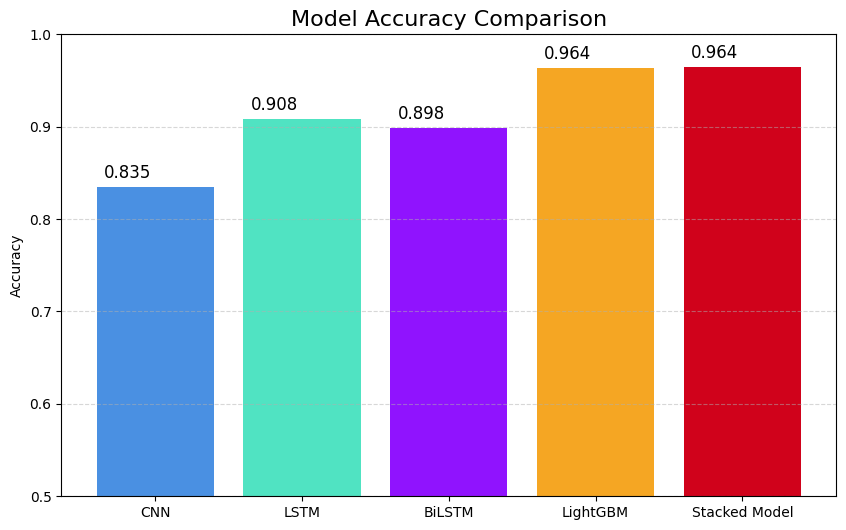

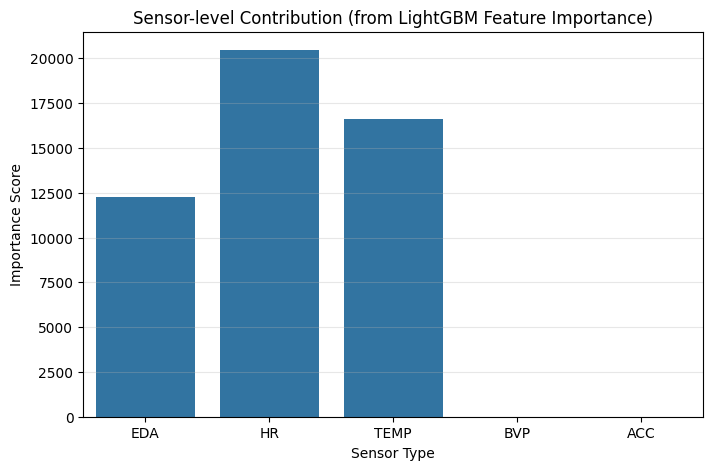

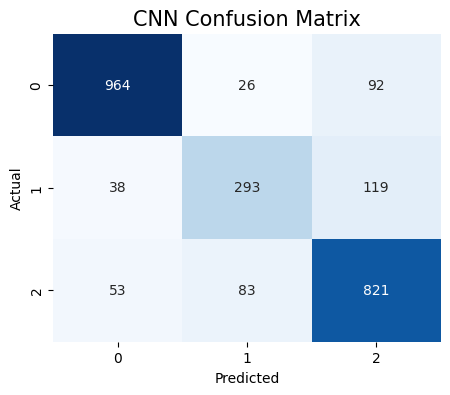

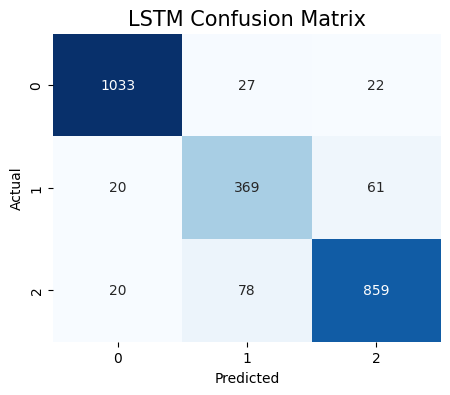

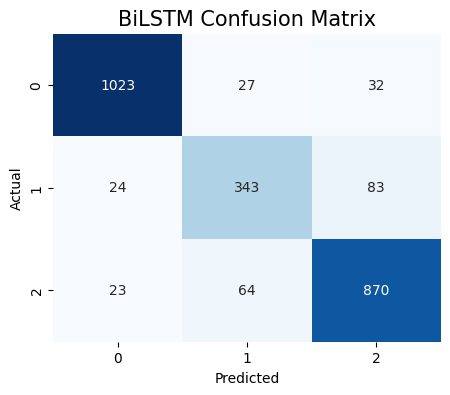

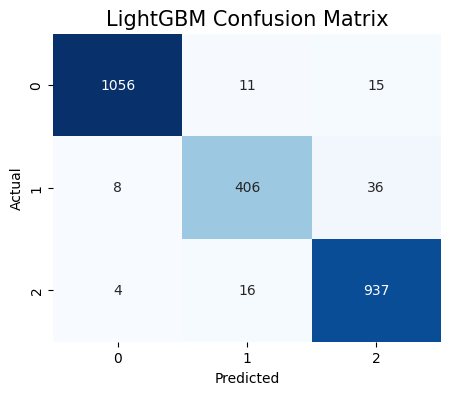

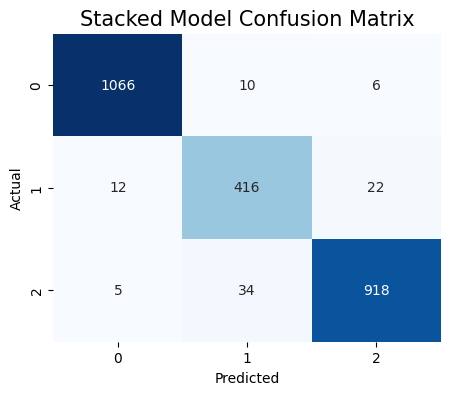

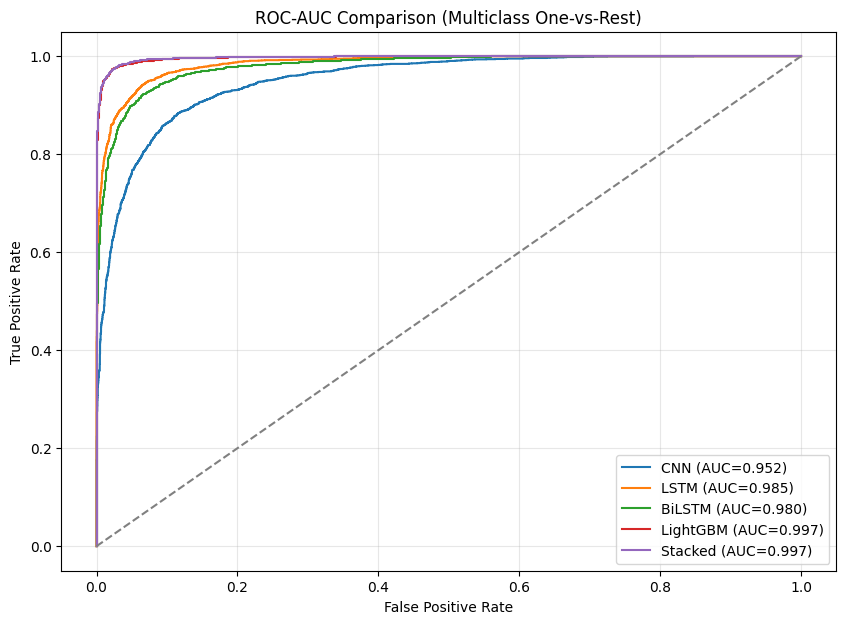

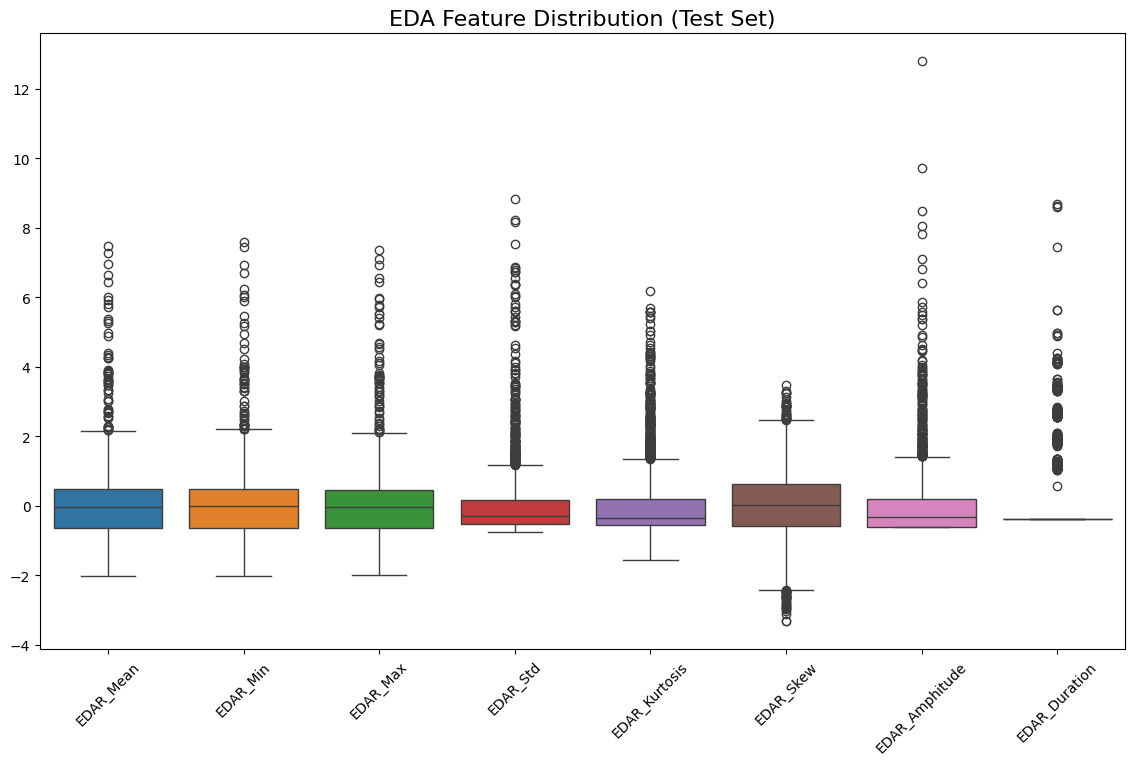

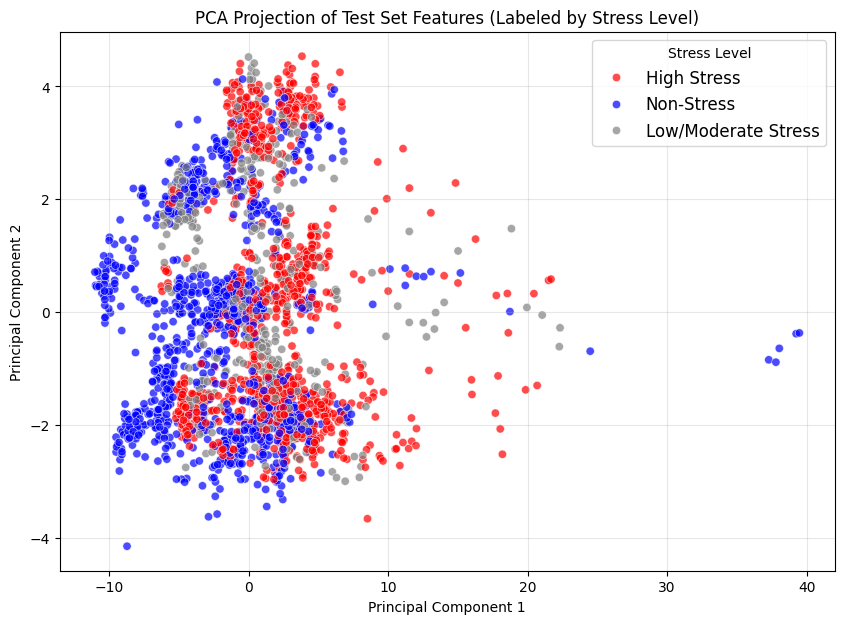

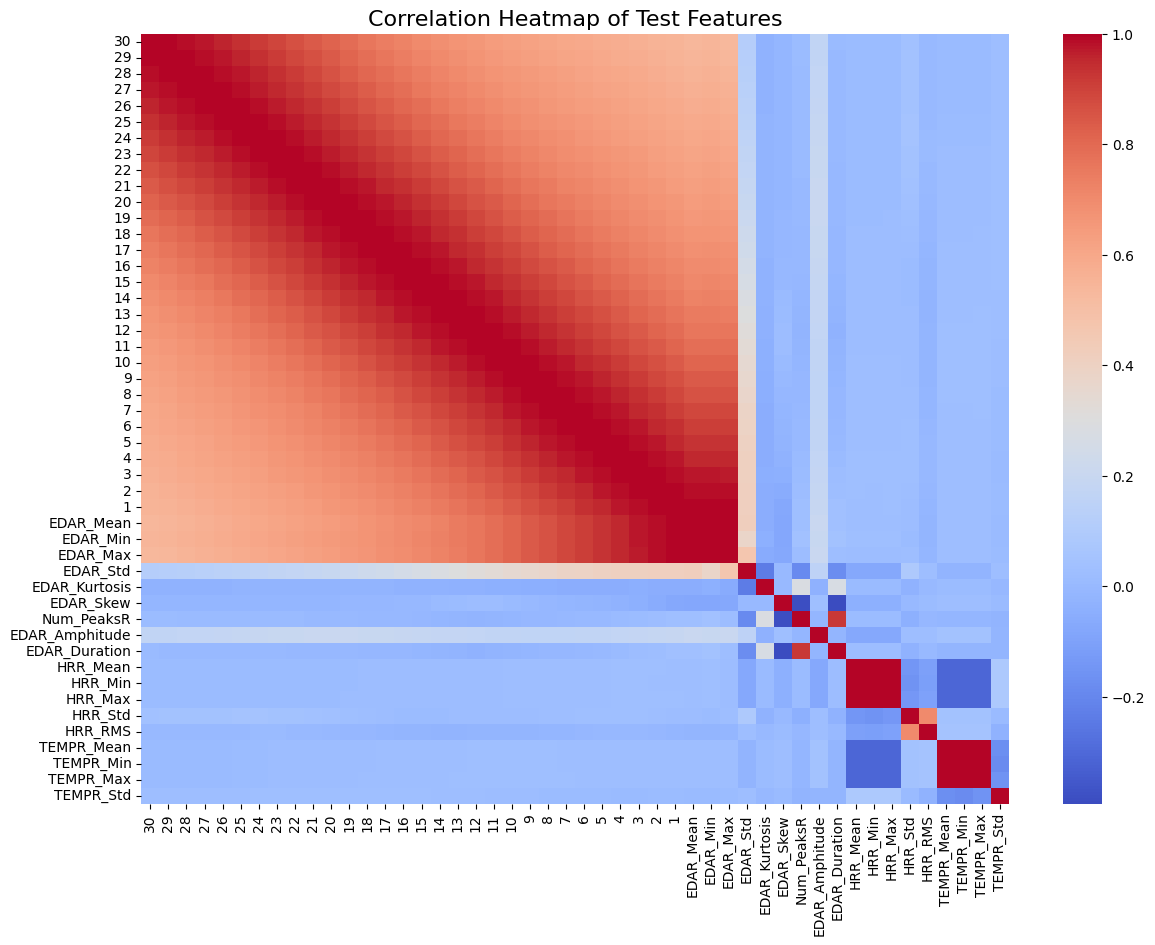

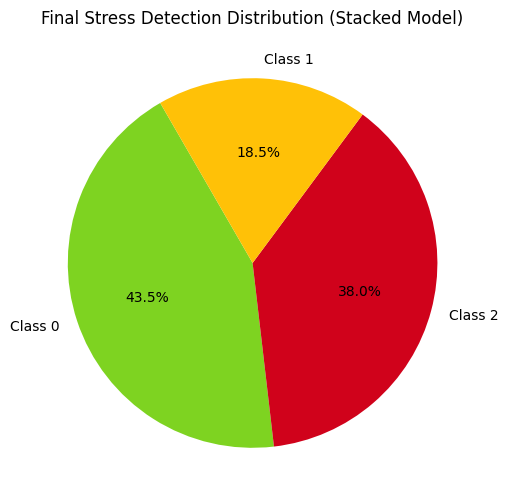

In [ ]:
  # CELL 10 — ADVANCED VISUALIZATION DASHBOARD


  import matplotlib.pyplot as plt
  import seaborn as sns
  import numpy as np
  import pandas as pd
  from sklearn.metrics import confusion_matrix, roc_curve, auc
  from sklearn.preprocessing import label_binarize

  # ---------------------------------------------------------
  # 1. MODEL ACCURACY COMPARISON (BAR CHART)
  # ---------------------------------------------------------
  model_names = ['CNN', 'LSTM', 'BiLSTM', 'LightGBM', 'Stacked Model']
  accuracies = [
      accuracy_score(y_test_full, cnn_preds),
      accuracy_score(y_test_full, lstm_preds),
      accuracy_score(y_test_full, bilstm_preds),
      accuracy_score(y_test_full, lgb_preds),
      accuracy_score(y_test_full, meta_preds)
  ]

  plt.figure(figsize=(10,6))
  bars = plt.bar(model_names, accuracies, color=['#4A90E2', '#50E3C2', '#9013FE', '#F5A623', '#D0021B'])
  plt.title('Model Accuracy Comparison', fontsize=16)
  plt.ylabel('Accuracy')
  plt.ylim(0.5, 1.0)
  plt.grid(axis='y', linestyle='--', alpha=0.5)

  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + 0.05, yval + 0.01, f"{yval:.3f}", fontsize=12)

  plt.show()

  # 2. Identify sensors by feature name patterns
  sensor_groups = {
      'EDA': [c for c in X.columns if "EDA" in c],
      'HR': [c for c in X.columns if "HR" in c],
      'TEMP': [c for c in X.columns if "TEMP" in c],
      'BVP': [c for c in X.columns if "BVP" in c],
      'ACC': [c for c in X.columns if "ACC" in c]
  }

  importances = lgbm_full.feature_importances_
  sensor_importance = {}

  for sensor, cols in sensor_groups.items():
      idx = [X.columns.get_loc(c) for c in cols]
      sensor_importance[sensor] = importances[idx].sum()

  plt.figure(figsize=(8,5))
  sns.barplot(x=list(sensor_importance.keys()), y=list(sensor_importance.values()))
  plt.title("Sensor-level Contribution (from LightGBM Feature Importance)")
  plt.ylabel("Importance Score")
  plt.xlabel("Sensor Type")
  plt.grid(axis='y', alpha=0.3)
  plt.show()


  # ---------------------------------------------------------
  # 2. CONFUSION MATRIX FOR ALL MODELS
  # ---------------------------------------------------------
  def show_cm(y_true, y_pred, title):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(5,4))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
      plt.title(title, fontsize=15)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.show()

  show_cm(y_test_full, cnn_preds, "CNN Confusion Matrix")
  show_cm(y_test_full, lstm_preds, "LSTM Confusion Matrix")
  show_cm(y_test_full, bilstm_preds, "BiLSTM Confusion Matrix")
  show_cm(y_test_full, lgb_preds, "LightGBM Confusion Matrix")
  show_cm(y_test_full, meta_preds, "Stacked Model Confusion Matrix")


  # ---------------------------------------------------------
  # 3. ROC CURVES (Multiclass → One-vs-Rest)
  # ---------------------------------------------------------
  plt.figure(figsize=(10,7))

  y_bin = label_binarize(y_test_full, classes=np.unique(y_test_full))

  models_proba = {
      "CNN": cnn_proba,
      "LSTM": lstm_proba,
      "BiLSTM": bilstm_proba,
      "LightGBM": lgb_proba,
      "Stacked": meta_proba
  }

  for name, proba in models_proba.items():
      try:
          fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
          auc_score = auc(fpr, tpr)
          plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")
      except:
          print(f"Skipping ROC for {name}")

  plt.plot([0,1],[0,1], '--', color='gray')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC-AUC Comparison (Multiclass One-vs-Rest)")
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

  # 4. Boxplot Summary per Sensor
  sensor_groups = {
      "EDA": [col for col in X_test_full.columns if "EDA" in col],
      "BVP": [col for col in X_test_full.columns if "BVP" in col],
      "HR":  [col for col in X_test_full.columns if "HR" in col],
      "TEMP": [col for col in X_test_full.columns if "TEMP" in col],
      "ACC": [col for col in X_test_full.columns if "ACC" in col],
  }

  plt.figure(figsize=(14,8))
  sns.boxplot(data=X_test_full[sensor_groups["EDA"]])
  plt.title("EDA Feature Distribution (Test Set)", fontsize=16)
  plt.xticks(rotation=45)
  plt.show()

  # 5. PCA 2D Scatter Plot
  from sklearn.decomposition import PCA

  # PCA on scaled features
  pca = PCA(n_components=2)
  pca_data = pca.fit_transform(X_test_full)

  pca_df = pd.DataFrame({
      "PC1": pca_data[:, 0],
      "PC2": pca_data[:, 1],
      "StressLabel": y_test_full
  })

  # Mapping numeric classes to text labels
  label_mapping = {
      0: "Non-Stress",
      1: "Low/Moderate Stress",
      2: "High Stress"
  }
  pca_df["Stress"] = pca_df["StressLabel"].map(label_mapping)

  plt.figure(figsize=(10,7))
  sns.scatterplot(
      data=pca_df,
      x="PC1",
      y="PC2",
      hue="Stress",
      palette={"Non-Stress":"blue", "Low/Moderate Stress":"grey", "High Stress":"red"},
      alpha=0.7
  )

  plt.title("PCA Projection of Test Set Features (Labeled by Stress Level)")
  plt.xlabel("Principal Component 1")
  plt.ylabel("Principal Component 2")
  plt.legend(title="Stress Level", fontsize=12)
  plt.grid(alpha=0.3)
  plt.show()

  # 6. Correlation Heatmap
  plt.figure(figsize=(14,10))
  sns.heatmap(X_test_full.corr(), cmap='coolwarm', annot=False)
  plt.title("Correlation Heatmap of Test Features", fontsize=16)
  plt.show()

  # ---------------------------------------------------------
  # 7. FINAL PREDICTION DISTRIBUTION (META MODEL)
  # ---------------------------------------------------------
  final_counts = pd.Series(meta_preds).value_counts()
  plt.figure(figsize=(6,6))
  plt.pie(final_counts, labels=[f"Class {c}" for c in final_counts.index], autopct='%1.1f%%',
          colors=['#7ED321', '#D0021B', '#FFC107'], startangle=120)
  plt.title("Final Stress Detection Distribution (Stacked Model)")
  plt.show()

In [ ]:
# =========================
# CELL 11: FINAL DECISION-AWARE STRESS INFERENCE ENGINE
# =========================

def final_stress_inference(tabular_samples, class_names=None):
    """
    Research-grade final inference engine.
    Combines ML + DL predictions, confidence, and agreement analysis.
    """

    if class_names is None:
        class_names = {0: "Non-Stress", 1: "Moderate Stress", 2: "High Stress"}

    # ---- Step 1: Scale input ----
    X_scaled = scaler.transform(tabular_samples.values)

    # ---- Step 2: Sequence conversion ----
    X_seq = tabular_to_seq(X_scaled, seq_len=SEQ_LEN)

    # ---- Step 3: Base model probabilities ----
    p_lgbm   = lgbm_full.predict_proba(X_scaled)
    p_cnn    = cnn_full.predict(X_seq)
    p_lstm   = lstm_full.predict(X_seq)
    p_bilstm = bilstm_full.predict(X_seq)

    # ---- Step 4: Meta features ----
    meta_features = np.hstack([p_lgbm, p_cnn, p_lstm, p_bilstm])

    # ---- Step 5: Meta decision ----
    final_proba = meta_clf.predict_proba(meta_features)
    final_pred  = meta_clf.predict(meta_features)

    # ---- Step 6: Agreement analysis ----
    base_preds = np.vstack([
        p_lgbm.argmax(axis=1),
        p_cnn.argmax(axis=1),
        p_lstm.argmax(axis=1),
        p_bilstm.argmax(axis=1)
    ]).T

    outputs = []

    for i in range(len(tabular_samples)):
        agreement = {
            "LightGBM": class_names[base_preds[i,0]],
            "CNN": class_names[base_preds[i,1]],
            "LSTM": class_names[base_preds[i,2]],
            "BiLSTM": class_names[base_preds[i,3]]
        }

        confidence = np.max(final_proba[i])

        if confidence > 0.9:
            risk = "Critical"
        elif confidence > 0.75:
            risk = "Elevated"
        else:
            risk = "Low"

        outputs.append({
            "Final_Stress_Label": class_names[final_pred[i]],
            "Confidence": round(float(confidence), 3),
            "Risk_Level": risk,
            "Model_Agreement": agreement,
            "Decision_Source": "OOF Stacked Meta-Learner"
        })

    return outputs

    # TEST FINAL OUTPUT ON 5 SAMPLES
results = final_stress_inference(X_test_full.iloc[:5])
results


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[{'Final_Stress_Label': 'High Stress',
  'Confidence': 0.998,
  'Risk_Level': 'Critical',
  'Model_Agreement': {'LightGBM': 'High Stress',
   'CNN': 'High Stress',
   'LSTM': 'Moderate Stress',
   'BiLSTM': 'High Stress'},
  'Decision_Source': 'OOF Stacked Meta-Learner'},
 {'Final_Stress_Label': 'High Stress',
  'Confidence': 0.78,
  'Risk_Level': 'Elevated',
  'Model_Agreement': {'LightGBM': 'Non-Stress',
   'CNN': 'Non-Stress',
   'LSTM': 'Moderate Stress',
   'BiLSTM': 'High Stress'},
  'Decision_Source': 'OOF Stacked Meta-Learner'},
 {'Final_Stress_Label': 'Non-Stress',
  'Confidence': 1.0,
  'Risk_Level': 'Critical',
  'Model_Agreement': {'LightGBM': 'Non-Stress',
   'CNN': 'Non-Stress',
   'LSTM': 'Non-Stress',
   'BiLSTM': 'Non-Stress'},
  'Decision_Source': 'OOF Stacked Meta-Learner'},
 {'Final_Stress_Label': 'Moderate Stress',
  'Confidence': 0.556,
  'Risk_Level': 'Low',
  'Model_Agreement': {'LightGBM': 'High Stress',
   'CNN': 'Non-Stress',
   'LSTM': 'Moderate Stress',
   

In [ ]:
# Cell 11: Final inference utility (4 models: LGBM + CNN + LSTM + BiLSTM)

def predict_final(tabular_samples):
    """
    Input:  tabular_samples (pandas DataFrame with same columns as training X)
    Output: dict with predicted label (meta) and per-class probability
    """

    # 1) Scale tabular input using fitted StandardScaler
    Xs = scaler.transform(tabular_samples.values)

    # 2) Convert to pseudo-sequences for CNN/LSTM/BiLSTM
    Xs_seq = tabular_to_seq(Xs, seq_len=SEQ_LEN)

    # 3) Base model probabilities
    # LightGBM
    lgb_p = lgbm_full.predict_proba(pd.DataFrame(Xs, columns=X.columns))

    # CNN
    cnn_p = cnn_full.predict(Xs_seq)

    # LSTM
    lstm_p = lstm_full.predict(Xs_seq)

    # BiLSTM
    bilstm_p = bilstm_full.predict(Xs_seq)

    # 4) Stack meta-features in the SAME ORDER used during training
    # order: [LGBM | CNN | LSTM | BiLSTM]
    meta_feats = np.hstack([lgb_p, cnn_p, lstm_p, bilstm_p])

    # 5) Predict final label using meta-learner
    final_prob = meta_clf.predict_proba(meta_feats)
    final_label = meta_clf.predict(meta_feats)

    return {
        'label': final_label,
        'proba': final_prob
    }


# Quick test on 5 samples
demo = predict_final(X_test_full.iloc[:5])
print("Demo labels:", demo['label'])
print("Demo probabilities shape:", demo['proba'].shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Demo labels: [2 2 0 1 2]
Demo probabilities shape: (5, 3)


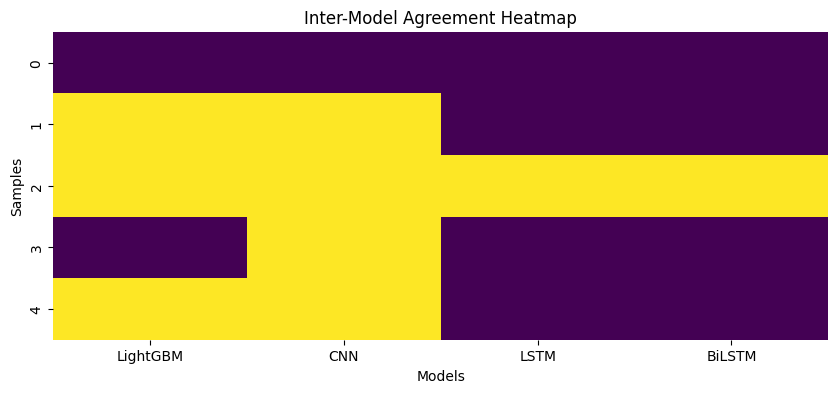

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

agreement_df = pd.DataFrame([
    {
        "LightGBM": o["Model_Agreement"]["LightGBM"],
        "CNN": o["Model_Agreement"]["CNN"],
        "LSTM": o["Model_Agreement"]["LSTM"],
        "BiLSTM": o["Model_Agreement"]["BiLSTM"],
    }
    for o in results # Changed 'outputs' to 'results'
])

plt.figure(figsize=(10,4))
sns.heatmap(agreement_df.apply(lambda x: x.astype('category').cat.codes),
            cmap="viridis", cbar=False)
plt.title("Inter-Model Agreement Heatmap")
plt.xlabel("Models")
plt.ylabel("Samples")
plt.show()